***Autoencoders***

We will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Finally, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder).

#Requirements

In [1]:
!pip3 install datasets skorch pandas torch torchinfo torchdata torchtext torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


#Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

# Data Loading

We load the `CIFAR-10 dataset`, available from `torchvision.datasets`. This dataset is one of the most popular benckmark in the filed of Computer Vision. It consits of $10$ different classes, that represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset contains $50,000$ training images and $10,000$ images for testing.

First, we will pre-process them with a `PreProcessing` fuction that works in the following way. The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between $0$ and $255$, and it represents a point of an image of size $32\times32$. We will normalize all values between $0$ and $1$, and we will flatten the $32\times32$ images into vectors of size $1024$.
Moreover, since no validation set is defined, we split the train set in a validation set and a new test set.
Finally, we design a custom dataset class, derived from the standard `Dataset` class, that returns a PyTorch Dataset object, along with its noisy version. The Gaussian noise is tunable with the `noise_factor` parameter and will be used for the Denoising Autoencoder.

In [3]:
to_tensor = transforms.ToTensor()

def PreProcessing(img):
    img = to_tensor(img) #PIL to tensor + Scaling
    img = torch.mean(img, 0) #One channel averaged over the colors
    img = img.reshape(torch.prod(torch.tensor(img.shape))) #Flattening
    return img.to(torch.float32)

In [4]:
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(PreProcessing)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(PreProcessing)) # 10000 samples

100%|██████████| 170498071/170498071 [00:08<00:00, 19562278.90it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 40000 
Validation samples = 10000 
Test samples = 10000


In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset, noise_factor, device='cpu'):
        super().__init__()
        self.dataset = dataset
        self.nf = noise_factor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        x_noisy = x + self.nf * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
        x_noisy = np.clip(x_noisy, 0., 1.).to(torch.float32)
        return (x.to(device), x_noisy.to(device))

#SVD

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linearly combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices, $V$ and $U$, and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in PyTorch as `torch.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [7]:
def svd_k(X, k):
    # k: sets the number of components to keep

    # Compute the matrix C
    C = torch.matmul(X.T, X)
    # SVD decomposition
    U, s_sqr, U_T = torch.linalg.svd(C)
    # Limit the number columns of U to k
    U_k = U[:,:k]
    return U_k

Now we create the dataset ready for the SVD:

In [8]:
device = torch.device("cpu") # for SVD
noise_factor = 0.1

x_train, x_train_noisy = next(iter(DataLoader(CustomDataset(train_data, noise_factor, device), batch_size=len(train_data))))
x_val, x_val_noisy = next(iter(DataLoader(CustomDataset(val_data, noise_factor, device), batch_size=len(val_data))))
x_test, x_test_noisy = next(iter(DataLoader(CustomDataset(test_data, noise_factor, device), batch_size=len(test_data))))

x_train.shape, x_train_noisy.shape, x_val.shape, x_val_noisy.shape, x_test.shape, x_test_noisy.shape

(torch.Size([40000, 1024]),
 torch.Size([40000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]),
 torch.Size([10000, 1024]))

Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and test set.


In [9]:
def SVD_Rec(emb_dim, out_test_reco=False):
    U_k = svd_k(x_train, emb_dim)
    x_training_svd = torch.matmul(x_train, U_k)
    x_test_svd = torch.matmul(x_test, U_k)
    x_training_reco = torch.matmul(x_training_svd, U_k.T)
    x_test_reco = torch.matmul(x_test_svd, U_k.T)
    accuracy_train = ((x_train - x_training_reco)**2).mean()
    accuracy_test = ((x_test - x_test_reco)**2).mean()
    if not out_test_reco:
        return accuracy_train, accuracy_test
    else:
        return accuracy_train, accuracy_test, x_test_reco

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [10]:
ENCODING_DIM = 256 # [TO COMPLETE]
accuracy_train, accuracy_test = SVD_Rec(ENCODING_DIM)
print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00150
Test mse: 0.00153


In [11]:
train_accuracies = {}
test_accuracies = {}

for emb_dim in [64, 128, 256, 384]:
    accuracy_train, accuracy_test = SVD_Rec(emb_dim)
    train_accuracies[emb_dim] = accuracy_train
    test_accuracies[emb_dim] = accuracy_test

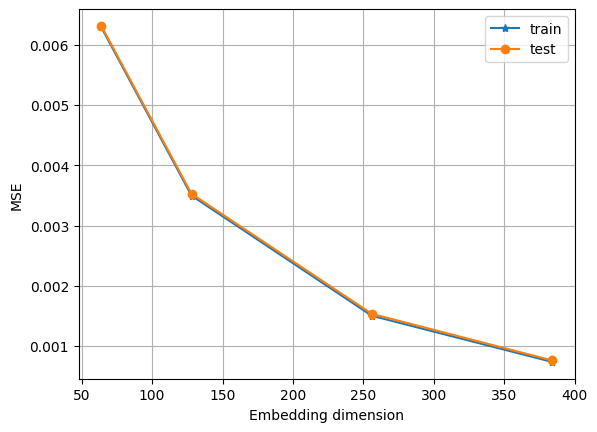

In [12]:
plt.plot(train_accuracies.keys(), train_accuracies.values(), marker='*', label='train')
plt.plot(test_accuracies.keys(), test_accuracies.values(), marker='o', label='test')
plt.grid()
plt.xlabel("Embedding dimension")
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

In [13]:
def plot_img(n, images_sets: list, title=""):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        for set_idx, images in enumerate(images_sets):
            ax = plt.subplot(len(images_sets), n, i + 1 + set_idx * n)
            plt.imshow(images[i].reshape(32, 32))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.suptitle(title)
    plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

Training mse: 0.00074
Test mse: 0.00076


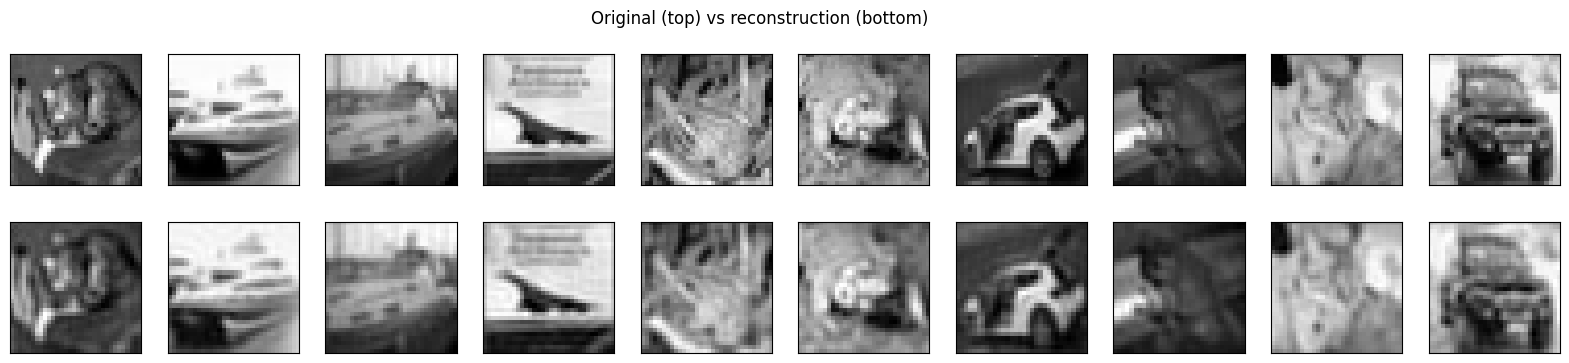

In [14]:
emb_dim = 384
train_acc, test_acc, x_test_reco = SVD_Rec(emb_dim, True)
print("Training mse: %.5f" % ( train_acc))
print("Test mse: %.5f" % ( test_acc))
_ = plot_img(10, [x_test, x_test_reco], title="Original (top) vs reconstruction (bottom)")

**ANSWER**: We observed that when we increased the ENCODING_DIM value during SVD parsing, the reconstruction mean square error decreased significantly. While low embedding sizes such as 64 give us higher MSE values, MSE decreases as we increase the embedding size to levels of 256, reflecting better reconstruction accuracy as more information is retained. At higher dimensions, such as 384, the MSE decreases further, resulting in reconstructions very close to the original images. The consistent variation of MSE indicates robust generalization of the SVD method. Therefore, higher dimensions preserve more detail, improving reconstruction quality.



# Shallow Linear Autoencoder

Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. First, we define the `DataLoader` to train the model.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
noise_factor = 0.3 # adjust the noise level here.

dataloader_train_AE = DataLoader(CustomDataset(train_data, noise_factor, device), batch_size = batch_size)
dataloader_val_AE = DataLoader(CustomDataset(val_data, noise_factor, device), batch_size = batch_size)
dataloader_test_AE = DataLoader(CustomDataset(test_data, noise_factor, device), batch_size = batch_size)

Then, we build our shallow Autoencoder. Here's a breakdown of the code to help you grasp how it works:

1. The `__init__` method is the initialization function for the Auto_Encoder class. It takes four parameters: `input_dim` (dimensionality of the input data), `enc_layers` (a list specifying the sizes of the encoder layers), `dec_layers` (a list specifying the sizes of the decoder layers), and `act_fun` (the activation function to be used).

2. The `nn.ModuleList()` is used to create empty lists E_layers and D_layers to store the encoder and decoder layers, respectively.

3. The `for loop `iterates over the `enc_layers` list to create the encoder layers. For the first layer, it creates a linear layer (`nn.Linear`) mapping from the input dimension to the size of the first encoder layer. For subsequent layers, it creates linear layers mapping between consecutive encoder layer sizes. The created layers are appended to the `self.E_layers` list.

4. The code then checks if the `dec_layers` list is empty. If it is empty, it creates a single linear layer mapping from the last encoder layer size to the input dimension (remember: the goal of the AE is to reconstruct the input). Otherwise, it iterates over the `dec_layers` list to create the decoder layers, similar to how the encoder layers were created. The last decoder layer is always mapped to the input dimension.

5. The `_init_weights` method is a helper function that initializes the weights of the linear layers. It is applied to all modules (layers) of the Auto_Encoder instance.

6. **[TO COMPLETE]** The `forward` method defines the forward pass of the Autoencoder. Your task is to complete the forward function and choose the appropriate activation function.

In [16]:
class Auto_Encoder(nn.Module):

    def __init__(self, input_dim, enc_layers, dec_layers, act_fun):
        super().__init__()

        self.E_layers = nn.ModuleList()
        self.D_layers = nn.ModuleList()
        self.act_fun = act_fun
        activation_functions = {'linear': transforms.Lambda(lambda x: x),
                                'sigmoid': F.sigmoid,
                                'relu': F.relu,
                                'tanh': F.tanh,
                                'leaky_relu': F.leaky_relu}

        assert self.act_fun in activation_functions, f'Activation Functions: {activation_functions.keys()}'
        self.af = activation_functions[self.act_fun]

        for layer_idx in range(len(enc_layers)):
            if layer_idx == 0:  # first layer, from input to enc
                self.E_layers.append(nn.Linear(input_dim, enc_layers[layer_idx]))
            else:  # hidden layers, depending on the input
                self.E_layers.append(nn.Linear(enc_layers[layer_idx-1], enc_layers[layer_idx]))

        if len(dec_layers) == 0:
            self.D_layers.append(nn.Linear(enc_layers[-1], input_dim))
        else:
            for layer_idx in range(len(dec_layers)):
                if layer_idx == 0:  # first layer, from enc to dec
                    self.D_layers.append(nn.Linear(enc_layers[-1], dec_layers[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.D_layers.append(nn.Linear(dec_layers[layer_idx-1], dec_layers[layer_idx]))

            self.D_layers.append(nn.Linear(dec_layers[-1], input_dim))  # final output layer

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        for layer in self.E_layers:
            x = self.af(layer(x))  
        for layer in self.D_layers[:-1]:
            x = self.af(layer(x))  
        if self.act_fun == 'linear': 
            return self.D_layers[-1](x)
        else:
            return F.sigmoid(self.D_layers[-1](x))  # last act func is always sigmoid


We check the results and compare them with the ones obtained with the SVD. In the cell at the end of this section (after the result of the linear autoencoder), give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.

We also try to be aquainted with the usual PyTorch training and evaluation routines. In the following part of the HW, the more training epochs the better the resutls, but it will also take longer. Feel free to change the `epochs` variable, just be consistent to make fair comparisons.

In [17]:
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [256]
DEC_LAYERS = []
ACT_FUN = 'linear'
lr = 0.005
epochs = 20 

Shallow_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 256]                262,400
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               263,168
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
Total mult-adds (M): 269.09
Input size (MB): 2.10
Forward/backward pass size (MB): 5.24
Params size (MB): 2.10
Estimated Total Size (MB): 9.44

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_AE.parameters(), lr=lr)

In [19]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs, print_step=1, tunning=False, denoising=False):
    loss_train, loss_val = [], []
    for epoch in range(epochs):

        model.train()
        total_count_train, n_train_batches, total_loss_train = 0, 0, 0
        for idx, (x, x_noisy) in enumerate(dataloader_train):
            optimizer.zero_grad()
            if denoising:
                x_rec = model(x_noisy)
            else:
                x_rec = model(x)
            loss = criterion(x_rec, x)
            total_loss_train += loss
            loss.backward()
            optimizer.step()

            total_count_train += x.size(0)
            n_train_batches += 1

        avg_loss_train = total_loss_train / n_train_batches
        loss_train.append(avg_loss_train.item())

        total_count_val, n_val_batches, total_loss_val = 0, 0, 0
        with torch.no_grad():
            model.eval()
            for idx, (x, x_noisy) in enumerate(dataloader_val):
                if denoising:
                    x_rec = model(x_noisy)
                else:
                    x_rec = model(x)

                loss = criterion(x_rec, x)
                total_loss_val += loss
                total_count_val += x.size(0)
                n_val_batches += 1

        avg_loss_val = total_loss_val / n_val_batches
        loss_val.append(avg_loss_val.item())
        if epoch % print_step == 0 and not tunning:
            print(f"epoch: {epoch+1} -> Loss: {avg_loss_train:.8f}", end=" ---------------- ")
            print(f"Val_Acc: Val_Loss: {avg_loss_val:.8f}")
    return loss_train, loss_val

In [20]:
start = timer()
loss_train, loss_val = train(Shallow_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.90680313 ---------------- Val_Acc: Val_Loss: 0.24711120
epoch: 2 -> Loss: 0.18924674 ---------------- Val_Acc: Val_Loss: 0.14715774
epoch: 3 -> Loss: 0.12181749 ---------------- Val_Acc: Val_Loss: 0.10179903
epoch: 4 -> Loss: 0.08733453 ---------------- Val_Acc: Val_Loss: 0.07620869
epoch: 5 -> Loss: 0.06652542 ---------------- Val_Acc: Val_Loss: 0.05941761
epoch: 6 -> Loss: 0.05281993 ---------------- Val_Acc: Val_Loss: 0.04806756
epoch: 7 -> Loss: 0.04319686 ---------------- Val_Acc: Val_Loss: 0.04000029
epoch: 8 -> Loss: 0.03619809 ---------------- Val_Acc: Val_Loss: 0.03415056
epoch: 9 -> Loss: 0.03097048 ---------------- Val_Acc: Val_Loss: 0.02915262
epoch: 10 -> Loss: 0.02690921 ---------------- Val_Acc: Val_Loss: 0.02540052
epoch: 11 -> Loss: 0.02361549 ---------------- Val_Acc: Val_Loss: 0.02245747
epoch: 12 -> Loss: 0.02095466 ---------------- Val_Acc: Val_Loss: 0.02020239
epoch: 13 -> Loss: 0.01881132 ---------------- Val_Acc: Val_Loss: 0.01821458
epoch: 1

In [21]:
def plot_learning_acc_and_loss(loss_tr, loss_val):
    info = {'loss_training':loss_tr, 'loss_validation':loss_val}
    df = pd.DataFrame(info)
    df.plot(figsize=(10, 8), subplots=[('loss_training','loss_validation')], grid=True)
    plt.xlabel("Epochs")
    plt.show()

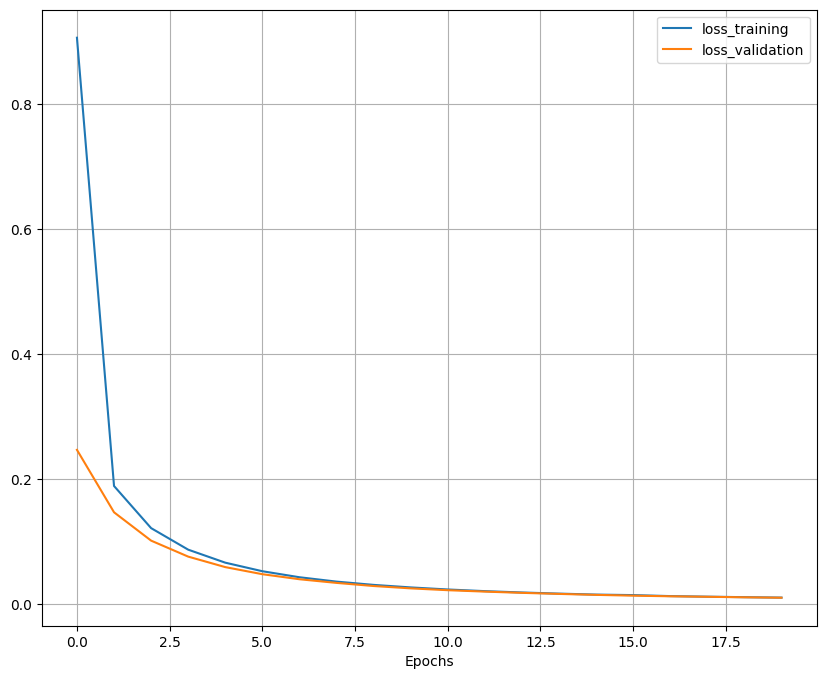

In [22]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [23]:
def test(model, dataloader_test=dataloader_test_AE, tunning=False, denoising=False):  # dataloader_test_AE not train
    model.eval()
    total_count_test, n_batches_test, loss = 0, 0, 0
    for idx, (x, x_noisy) in enumerate(dataloader_test):
        if denoising:
            x_rec = model(x_noisy)
        else:
            x_rec = model(x)
        loss += criterion(x_rec, x)
        total_count_test += x.size(0)
        n_batches_test += 1
    loss_test = loss / n_batches_test
    if not tunning:
        print(f"Test Loss: {loss_test:.8f}")
    else:
        return loss_test

In [24]:
test(Shallow_AE)

Test Loss: 0.01042583


In [25]:
train_mse = {}
test_mse = {}
epochs = 15 # just to test
for emb_dim in [16, 32, 64, 128, 256]:
    ENC_LAYERS = [emb_dim]
    Shallow_AE_Cand = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
    optimizer = torch.optim.Adam(Shallow_AE_Cand.parameters(), lr=lr)
    loss_train, _ = train(Shallow_AE_Cand, optimizer, dataloader_train_AE,
                          dataloader_val_AE, epochs, tunning=True)

    train_mse[emb_dim] = loss_train[-1]
    test_mse[emb_dim] = test(Shallow_AE_Cand, tunning=True).item()

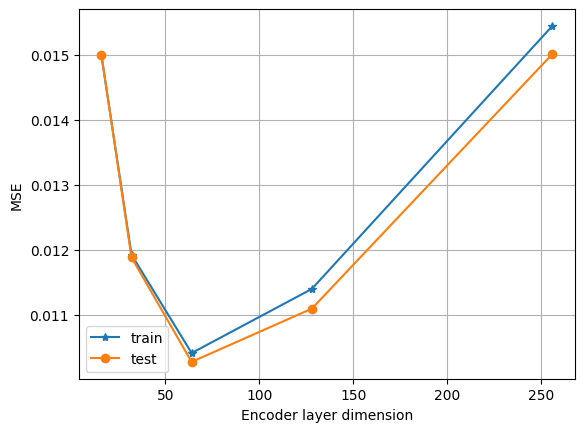

In [26]:
plt.plot(train_mse.keys(), train_mse.values(), marker='*', label='train')
plt.plot(test_mse.keys(), test_mse.values(), marker='o', label='test')
plt.grid()
plt.xlabel("Encoder layer dimension")
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

In [27]:
BEST_ENC_LAYERS = [64] # should be changed to the best one.
epochs = 30 # try with higher number than before
BEST_Shallow_AE = Auto_Encoder(IN_DIM, BEST_ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
optimizer = torch.optim.Adam(BEST_Shallow_AE.parameters(), lr=lr)
_, _ = train(BEST_Shallow_AE, optimizer, dataloader_train_AE, dataloader_val_AE, epochs)

epoch: 1 -> Loss: 0.26758790 ---------------- Val_Acc: Val_Loss: 0.08486171
epoch: 2 -> Loss: 0.06614646 ---------------- Val_Acc: Val_Loss: 0.05154809
epoch: 3 -> Loss: 0.04358945 ---------------- Val_Acc: Val_Loss: 0.03684371
epoch: 4 -> Loss: 0.03244264 ---------------- Val_Acc: Val_Loss: 0.02858404
epoch: 5 -> Loss: 0.02608513 ---------------- Val_Acc: Val_Loss: 0.02357612
epoch: 6 -> Loss: 0.02192515 ---------------- Val_Acc: Val_Loss: 0.02019611
epoch: 7 -> Loss: 0.01901872 ---------------- Val_Acc: Val_Loss: 0.01775474
epoch: 8 -> Loss: 0.01687547 ---------------- Val_Acc: Val_Loss: 0.01595548
epoch: 9 -> Loss: 0.01529250 ---------------- Val_Acc: Val_Loss: 0.01458891
epoch: 10 -> Loss: 0.01405825 ---------------- Val_Acc: Val_Loss: 0.01349980
epoch: 11 -> Loss: 0.01306737 ---------------- Val_Acc: Val_Loss: 0.01261137
epoch: 12 -> Loss: 0.01225593 ---------------- Val_Acc: Val_Loss: 0.01188002
epoch: 13 -> Loss: 0.01158302 ---------------- Val_Acc: Val_Loss: 0.01127208
epoch: 1

In [28]:
@torch.no_grad()
def apply_on_test(model, device, denoising=False):
    if denoising:
        x = x_test_noisy.to(device)
    else:
        x = x_test.to(device)
    for layer in model.E_layers:
        x = model.af(layer(x))
    encoded_imgs = x


    y = encoded_imgs
    for layer in model.D_layers[:-1]:
        y = model.af(layer(y))
    if model.act_fun == 'linear':
        decoded_imgs = model.D_layers[-1](y)
    else:
        decoded_imgs = F.sigmoid(model.D_layers[-1](y))

    return (encoded_imgs.to("cpu"), decoded_imgs.to("cpu"))

In [29]:
# encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_AE, device=device)
encoded_imgs, decoded_imgs = apply_on_test(model=BEST_Shallow_AE, device=device)

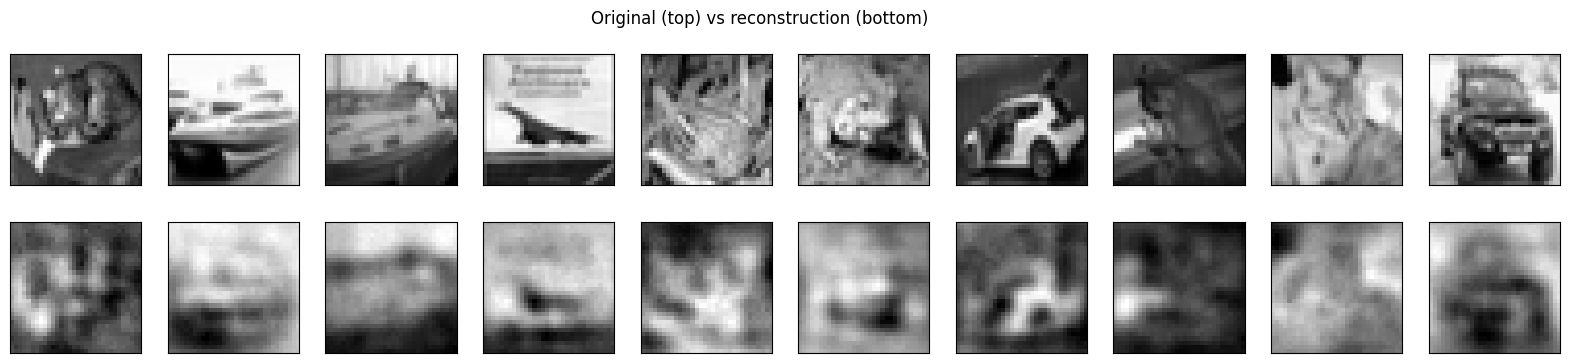

In [30]:
plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

Let' s comment the results obtained with the shallow linear autoencoder in relation to the ones obtained by the SVD decomposition. Are they different or similar? Why do you think they are so? (hint: consider the theoretical relationship between SVD and a shallow linear autoencoder.)

**ANSWER**: The results obtained with the shallow linear autoencoder are similar to those obtained by SVD decomposition due to their theoretical equivalence. Both methods aim to reduce the dimensionality of input data while retaining its most significant features, and they minimize reconstruction error, typically measured by mean squared error. A shallow linear AE without an activation function essentially performs a similar transformation as SVD, with the encoder layer analogous to the left singular vectors and the decoder layer corresponding to the right singular vectors. This similarity is evident in their comparable reconstruction errors, particularly when the AE uses a linear activation function and matches the number of encoding dimensions to the principal components retained in SVD. Therefore, the close relationship between their reconstruction performance underscores the mathematical equivalence of SVD and a shallow linear AE, with the AE serving as an iterative, data-driven approach to achieving similar outcomes in dimensionality reduction and data reconstruction.

# Shallow non-linear Autoencoder

 We replicate the code of the previous exercise but in this case, instead of using linear activation functions use non-linear ones. We choose the most appropriate non-linear function, and motivate your choice in the last cell of this section. Discuss the results you obtained in relation to those obtained with the Shallow Linear Autoencoder.

In [31]:
# define model and training hyperparameters
IN_DIM = x_train.shape[-1]
ENC_LAYERS = [64]
DEC_LAYERS = []
ACT_FUN = 'sigmoid'
lr = 0.005
epochs = 35


Shallow_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(Shallow_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 64]                 65,600
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               66,560
Total params: 132,160
Trainable params: 132,160
Non-trainable params: 0
Total mult-adds (M): 67.67
Input size (MB): 2.10
Forward/backward pass size (MB): 4.46
Params size (MB): 0.53
Estimated Total Size (MB): 7.08

In [32]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Shallow_non_AE.parameters(), lr=lr)

In [33]:
start = timer()
loss_train, loss_val = train(Shallow_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04468061 ---------------- Val_Acc: Val_Loss: 0.03269703
epoch: 2 -> Loss: 0.02783381 ---------------- Val_Acc: Val_Loss: 0.02320048
epoch: 3 -> Loss: 0.02160408 ---------------- Val_Acc: Val_Loss: 0.01894978
epoch: 4 -> Loss: 0.01875368 ---------------- Val_Acc: Val_Loss: 0.01667558
epoch: 5 -> Loss: 0.01615220 ---------------- Val_Acc: Val_Loss: 0.01517448
epoch: 6 -> Loss: 0.01506678 ---------------- Val_Acc: Val_Loss: 0.01397762
epoch: 7 -> Loss: 0.01394662 ---------------- Val_Acc: Val_Loss: 0.01307876
epoch: 8 -> Loss: 0.01332120 ---------------- Val_Acc: Val_Loss: 0.01266957
epoch: 9 -> Loss: 0.01284220 ---------------- Val_Acc: Val_Loss: 0.01206203
epoch: 10 -> Loss: 0.01220967 ---------------- Val_Acc: Val_Loss: 0.01170841
epoch: 11 -> Loss: 0.01191149 ---------------- Val_Acc: Val_Loss: 0.01155861
epoch: 12 -> Loss: 0.01201732 ---------------- Val_Acc: Val_Loss: 0.01122716
epoch: 13 -> Loss: 0.01151269 ---------------- Val_Acc: Val_Loss: 0.01128702
epoch: 1

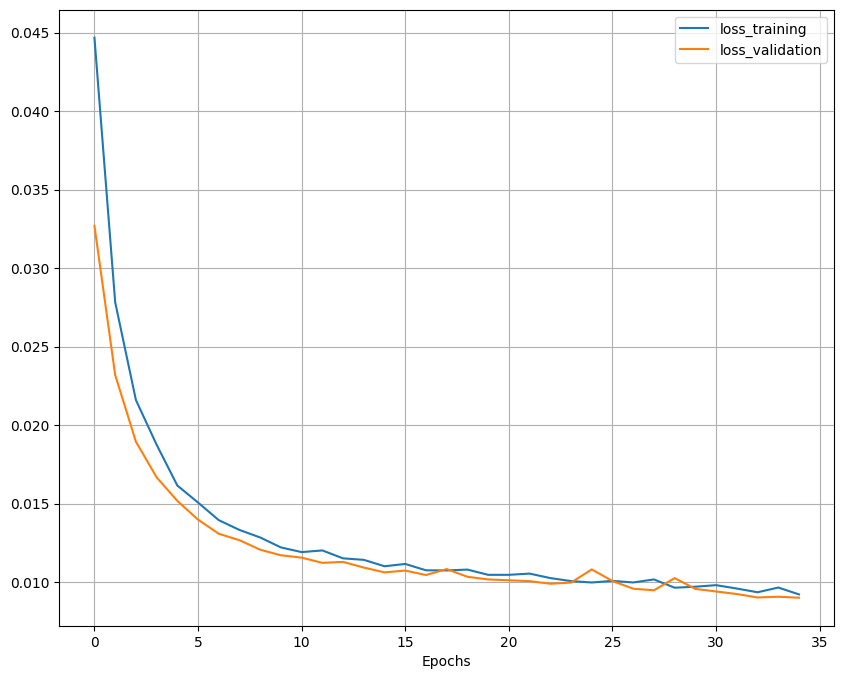

In [34]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [35]:
test(Shallow_non_AE)

Test Loss: 0.00903770


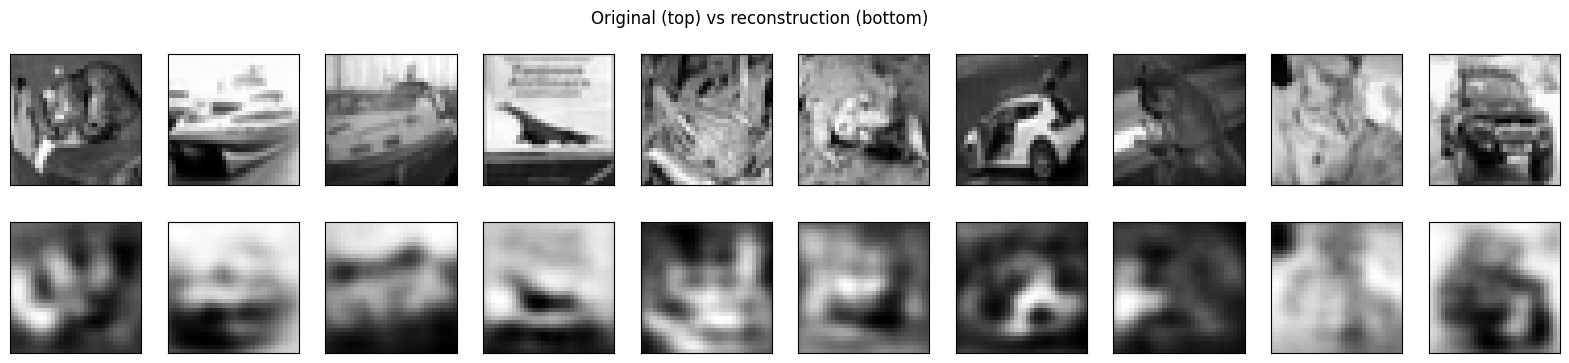

In [36]:
encoded_imgs, decoded_imgs = apply_on_test(model=Shallow_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

We discuss the results you obtained with the activation functions you have tested and also motivate your choice. We compare your results to the ones obtained with the Shallow Linear Autoencoder.

**ANSWER**:

linear   0.00758147
sigmoid   0.00988467
tanh   0.01383329
relu   0.03868495
leaky_Relu   0.01094552

Based on my results, it is clear that linear activation provides the lowest reconstruction error compared to sigmoid, tanh, ReLU and leaky ReLU activations. Error measurements clearly show that the linear activation function performs better in preserving information and accurately reconstructing the input data. This choice is particularly due to the ability to directly output values ​​without compressing them into specific ranges; This is crucial for tasks where the output data distribution is not inherently limited. In contrast, sigmoid, tanh, and ReLU-based activations showed higher errors; this suggests that they may not be suitable for the reconstruction task.

`%ENDTEXT`

# Deep Autoencoder

**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to **use at least $5$ layers**. The model will use 𝑛 layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g. `IN_DIM` → $k$ → $k/2$, where $k/2$ is the arbitrarly chosen encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e., $k$ → `IN_DIM`, the resulting overall structure recalls an hourglass!). Try different hyperparameters configurations and write a short report of your experiments below. Leave the best execution in the code cells.

In [37]:
# define model and training hyperparameters

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [1024, 512,256,128,64,32]
DEC_LAYERS = [64,128,256,512,1024]
ACT_FUN = 'relu'
lr = 1e-3
epochs = 25


DEEP_non_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(DEEP_non_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 1024]               1,049,600
│    └─Linear: 2-2                       [512, 512]                524,800
│    └─Linear: 2-3                       [512, 256]                131,328
│    └─Linear: 2-4                       [512, 128]                32,896
│    └─Linear: 2-5                       [512, 64]                 8,256
│    └─Linear: 2-6                       [512, 32]                 2,080
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-7                       [512, 64]                 2,112
│    └─Linear: 2-8                       [512, 128]                8,320
│    └─Linear: 2-9                       [512, 256]                33,024
│    └─Linear: 2-10                      [512, 5

In [38]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DEEP_non_AE.parameters(), lr=lr)

In [39]:
start = timer()
loss_train, loss_val = train(DEEP_non_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Loss: 0.04633088 ---------------- Val_Acc: Val_Loss: 0.03093020
epoch: 2 -> Loss: 0.02825429 ---------------- Val_Acc: Val_Loss: 0.02674800
epoch: 3 -> Loss: 0.02560507 ---------------- Val_Acc: Val_Loss: 0.02445608
epoch: 4 -> Loss: 0.02357811 ---------------- Val_Acc: Val_Loss: 0.02253925
epoch: 5 -> Loss: 0.02251153 ---------------- Val_Acc: Val_Loss: 0.02235906
epoch: 6 -> Loss: 0.02219632 ---------------- Val_Acc: Val_Loss: 0.02171946
epoch: 7 -> Loss: 0.02162349 ---------------- Val_Acc: Val_Loss: 0.02073083
epoch: 8 -> Loss: 0.02084599 ---------------- Val_Acc: Val_Loss: 0.02069325
epoch: 9 -> Loss: 0.02074933 ---------------- Val_Acc: Val_Loss: 0.02061497
epoch: 10 -> Loss: 0.02037731 ---------------- Val_Acc: Val_Loss: 0.01965051
epoch: 11 -> Loss: 0.01956493 ---------------- Val_Acc: Val_Loss: 0.01925338
epoch: 12 -> Loss: 0.01936700 ---------------- Val_Acc: Val_Loss: 0.01917016
epoch: 13 -> Loss: 0.01934810 ---------------- Val_Acc: Val_Loss: 0.01870259
epoch: 1

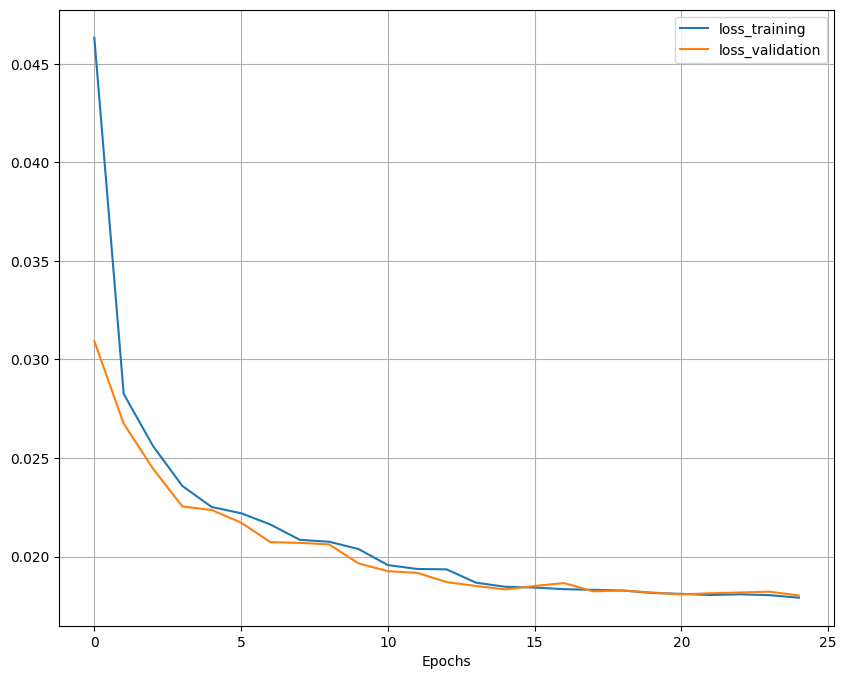

In [40]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [41]:
test(DEEP_non_AE)

Test Loss: 0.01820466


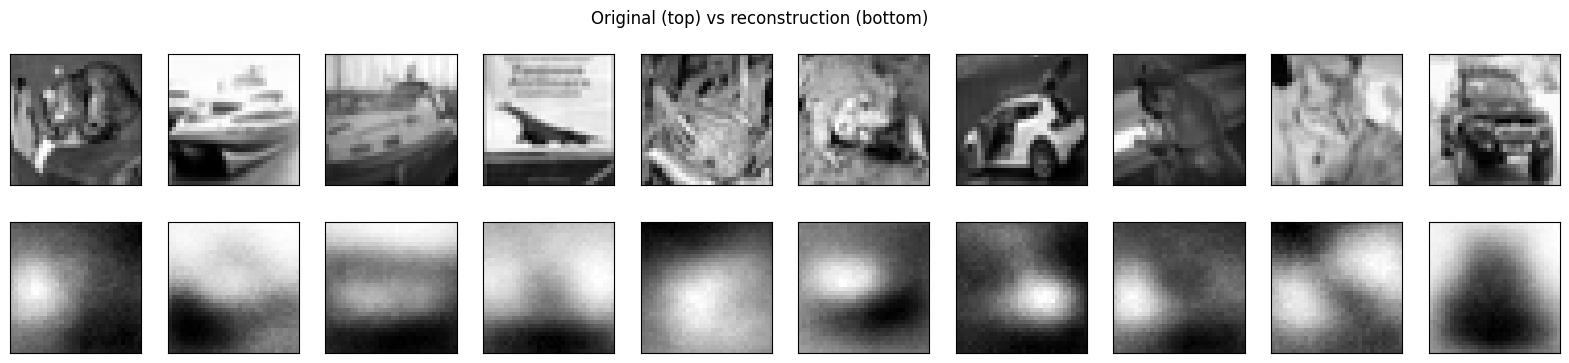

In [42]:
encoded_imgs, decoded_imgs = apply_on_test(model=DEEP_non_AE, device=device)

plot_img(10, [x_test, decoded_imgs], title="Original (top) vs reconstruction (bottom)")

A short report of the results you obtained trying different hyperparameters configurations.

**ANSWER**:  
 The test loss data from various activation functions illustrate the impact of activation functions on model performance. The linear activation function was most effective in terms of minimizing test loss, while ReLU showed the least effectiveness. Sigmoid, tanh, and leaky ReLU activation functions presented varying degrees of effectiveness, with sigmoid and leaky ReLU demonstrating relatively better performance than tanh. These findings suggest that the choice of activation function can significantly influence the model's learning process and its ultimate effectiveness.

# Shallow Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. We have defined a Dataloader able to return a noisy version of the input data. You can activate this capability by passing the parameter `denoising=True` to the `train` function.

Run some experiments with different hyperparameters values, and write a short report of your findings below. You can also re-create the dataloaders at the beginning of the notebook and test what happens if you increase the noise level above $0.1$.

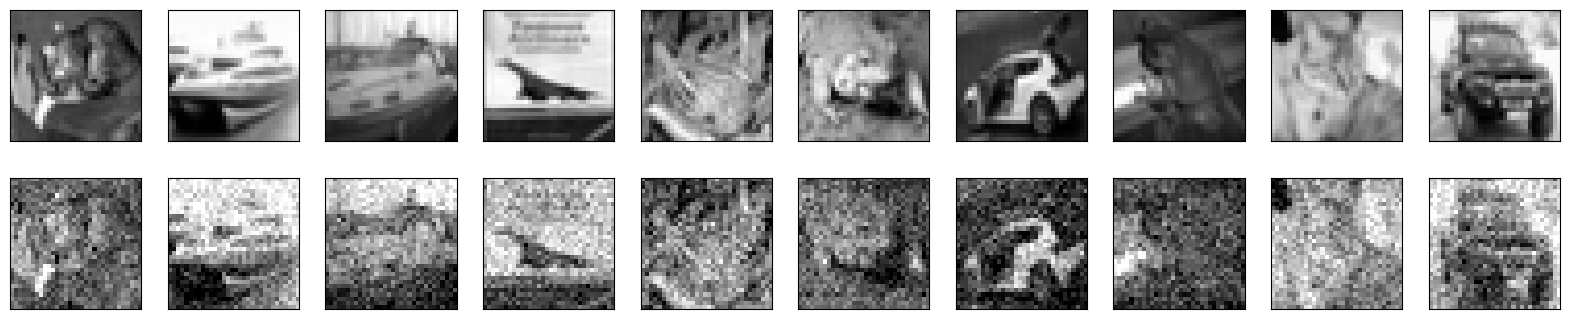

In [43]:
plot_img(10, [x_test, x_test_noisy])

In [44]:
# define model and training hyperparameters

IN_DIM = x_train.shape[-1]
ENC_LAYERS = [64]
DEC_LAYERS = []
ACT_FUN = 'linear'
lr = 0.0001
epochs = 25



SHALLOW_denoising_AE = Auto_Encoder(IN_DIM, ENC_LAYERS, DEC_LAYERS, ACT_FUN).to(device)
summary(SHALLOW_denoising_AE, input_size=(batch_size, IN_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Auto_Encoder                             [512, 1024]               --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [512, 64]                 65,600
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-2                       [512, 1024]               66,560
Total params: 132,160
Trainable params: 132,160
Non-trainable params: 0
Total mult-adds (M): 67.67
Input size (MB): 2.10
Forward/backward pass size (MB): 4.46
Params size (MB): 0.53
Estimated Total Size (MB): 7.08

In [45]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SHALLOW_denoising_AE.parameters(), lr=lr)

In [46]:
start = timer()
loss_train, loss_val = train(SHALLOW_denoising_AE, optimizer, dataloader_train_AE,
                             dataloader_val_AE, epochs, denoising= True)

end = timer()
print(f"Training time in second: {round(end - start)}")

epoch: 1 -> Loss: 1.09441042 ---------------- Val_Acc: Val_Loss: 0.80647326
epoch: 2 -> Loss: 0.74060059 ---------------- Val_Acc: Val_Loss: 0.67899245
epoch: 3 -> Loss: 0.61648917 ---------------- Val_Acc: Val_Loss: 0.55513406
epoch: 4 -> Loss: 0.50814426 ---------------- Val_Acc: Val_Loss: 0.47184190
epoch: 5 -> Loss: 0.44020724 ---------------- Val_Acc: Val_Loss: 0.41567069
epoch: 6 -> Loss: 0.39665335 ---------------- Val_Acc: Val_Loss: 0.37939915
epoch: 7 -> Loss: 0.36275905 ---------------- Val_Acc: Val_Loss: 0.34815249
epoch: 8 -> Loss: 0.33420029 ---------------- Val_Acc: Val_Loss: 0.32134250
epoch: 9 -> Loss: 0.30800959 ---------------- Val_Acc: Val_Loss: 0.29535049
epoch: 10 -> Loss: 0.28454265 ---------------- Val_Acc: Val_Loss: 0.27428398
epoch: 11 -> Loss: 0.26348111 ---------------- Val_Acc: Val_Loss: 0.25320184
epoch: 12 -> Loss: 0.24379390 ---------------- Val_Acc: Val_Loss: 0.23458123
epoch: 13 -> Loss: 0.22606169 ---------------- Val_Acc: Val_Loss: 0.21745537
epoch: 1

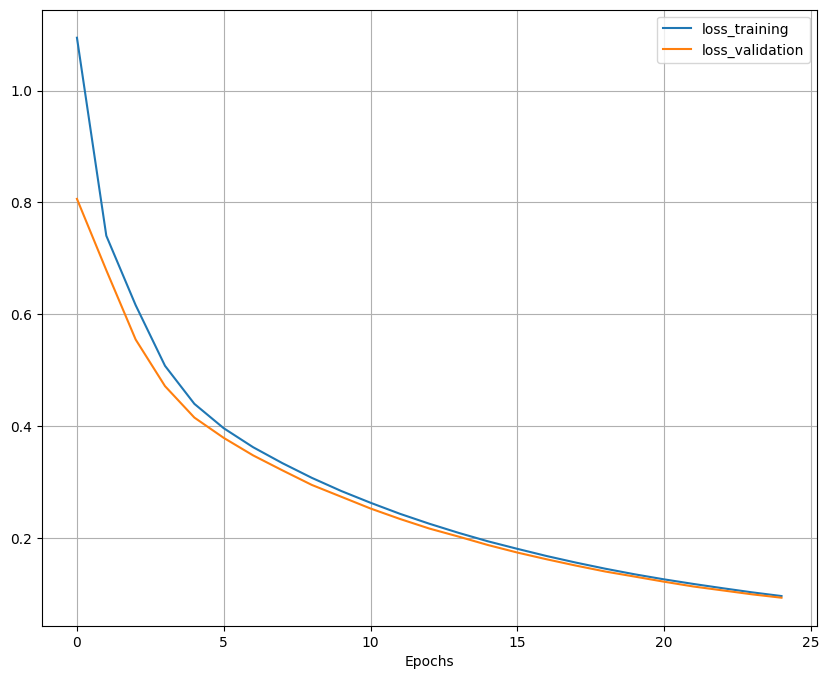

In [47]:
plot_learning_acc_and_loss(loss_train, loss_val)

In [48]:
test(SHALLOW_denoising_AE, denoising=True)

Test Loss: 0.09382913


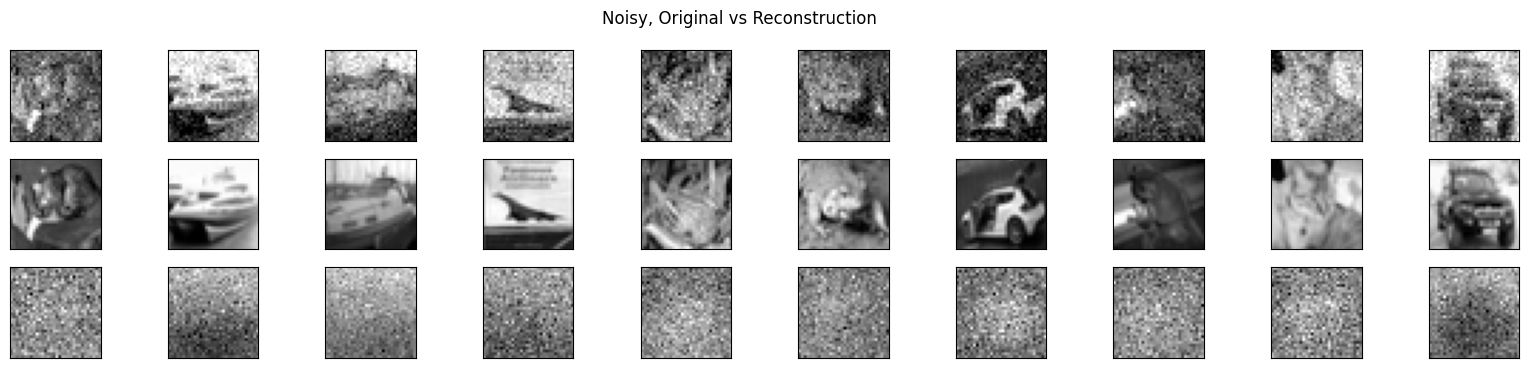

In [49]:
encoded_imgs, decoded_imgs = apply_on_test(model=SHALLOW_denoising_AE, device=device, denoising=True)

plot_img(10, [x_test_noisy, x_test, decoded_imgs], title="Noisy, Original vs Reconstruction")

How strong is the impact of the noise factor on the model's denoising capability? What hyperparameter configuration worked for the noise levels you have tried?

The impact of the noise factor on a denoising autoencoder's ability to reconstruct clean images is significant and directly affects its performance. The noise factor determines the level of noise added to the original input data to create a noisy version for training. A higher noise factor increases the difficulty of the denoising task and forces the autoencoder to learn robust representations that can effectively filter out noise. Conversely, a lower noise factor may lead to less challenging denoising scenarios where the model may not generalize well to noisier real-world data. Moderate noise tends to produce the best results, allowing the model to learn meaningful representations and also providing a clear signal for reconstruction.